In [1]:
import h5py
import brighteyes_flim
import matplotlib.pyplot as plt
import numpy as np
import brighteyes_ism.analysis.Graph_lib as gr
import brighteyes_ism.dataio.mcs as mcs
from scipy.optimize import curve_fit
from skimage.filters import gaussian
import scipy.signal
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift

## Confocal processing

### Open the dataset 4D (x,y,t,ch) of the TTM's IRF

In [2]:
h = h5py.File(r"C:\Users\fdelbufalo\Desktop\images\Gold_beads_17_luglio_2024_TTM_IRF\gold_beads_4d","r")
print(h.keys())
img = h["image_4d"]
print(img.shape)

<KeysViewHDF5 ['image_4d']>
(500, 500, 260, 25)


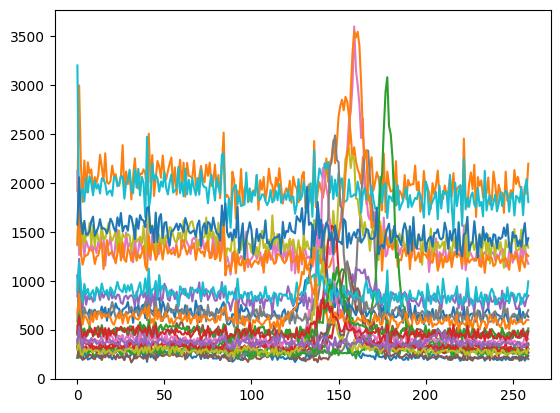

In [3]:
plt.figure()
img_hist = np.sum(img, axis=(0,1))
for j in range(img_hist.shape[-1]):
    plt.plot(img_hist[:, j])

### Clean IRF

In [4]:
nch = 25
print("nchannels", nch)

shift_vec = np.empty( nch )

for i in range(nch):
    shift_vec[i], *_ = phase_cross_correlation(img_hist[:, 12], img_hist[:, i], upsample_factor=10, normalization=None)


hist_shifted = np.empty_like(img_hist)
for i in range(nch):
    hist_shifted[:, i] = shift(img_hist[:, i], shift_vec[i], order = 1, mode='grid-wrap')

nchannels 25


C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_7568\2678903453.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shift_vec[i], *_ = phase_cross_correlation(img_hist[:, 12], img_hist[:, i], upsample_factor=10, normalization=None)


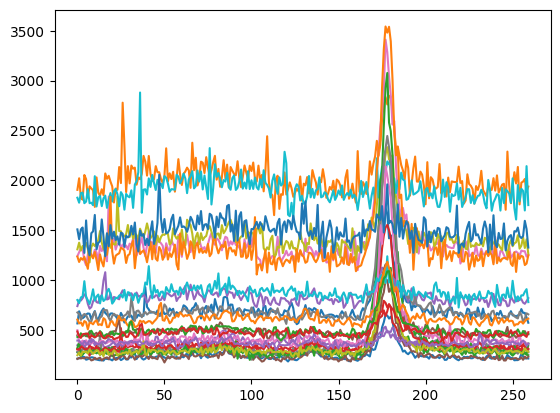

In [5]:
plt.figure()
for i in range(hist_shifted.shape[-1]):
    plt.plot(hist_shifted[:, i])


(260, 25)


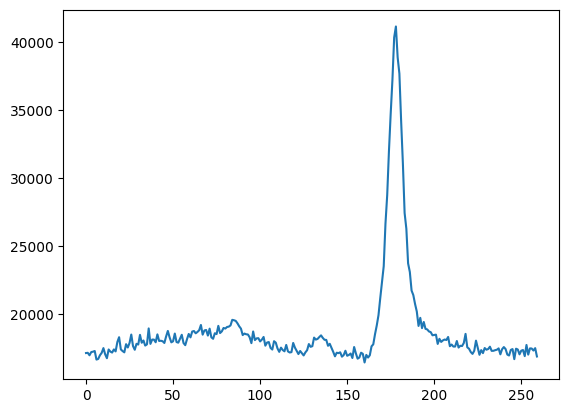

In [6]:
print(hist_shifted.shape)
irf_sum = np.sum(hist_shifted, axis = -1)
plt.figure()
plt.plot(irf_sum)

17927.266666666666


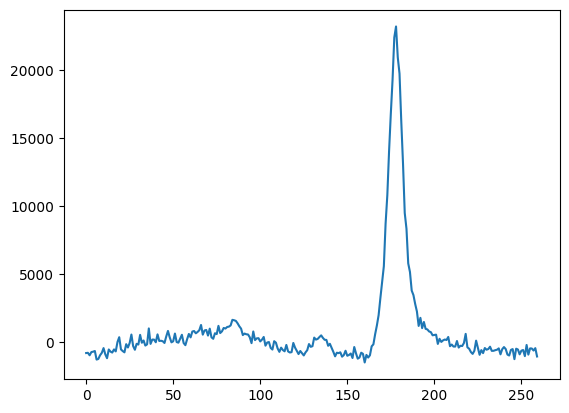

In [7]:
offset = np.mean(irf_sum[0:150])
print(offset)
irf_without_offset = irf_sum - offset
plt.figure()
plt.plot(irf_without_offset)

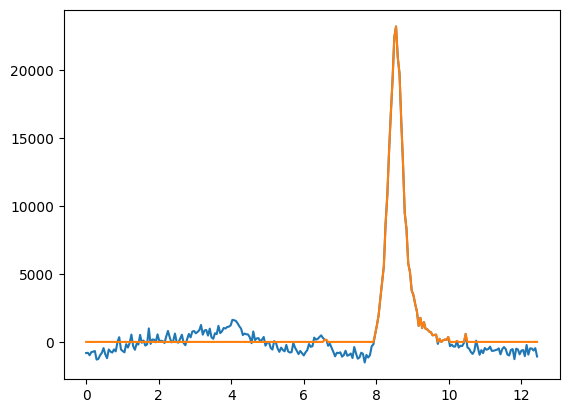

In [8]:
def centroid(data):
    x = np.arange(data.size)
    idx = np.sum(x*data)/data.sum()
    return idx

def clean_irf(irf, threshold = 0.3, window = 6):
    
    time = np.arange(irf.size)
    
    t_irf = np.where(irf>threshold, irf, 0)
    
    t0 = centroid(t_irf)
    
    indices = np.argwhere(np.logical_and(time > t0 - window, time < t0 + window))
    
    final_irf = np.zeros_like(irf)
    
    final_irf[indices] = irf[indices]
    
    return final_irf

final_irf = np.empty_like(irf_without_offset)
dt = 0.048
time = np.arange(260) * dt

#for n in range(img_hist.shape[-1]):

irf = irf_without_offset
 
final_irf = clean_irf(irf, threshold = 3000, window = 2/dt)
final_irf = np.where(final_irf>0, final_irf, 0)    
plt.figure()
plt.plot(time, irf)
plt.plot(time, final_irf)

### Open the raw 4D image's histograms not calibrated

In [9]:
h_1 = h5py.File(r"C:\Users\fdelbufalo\Desktop\images\Convallaria_29_luglio_2024\convallaria_LP53_500us_50um_300x300_Raw_4D","r")
print(h_1.keys())
img_data = h_1["image_4d"]
print(img_data.shape)

<KeysViewHDF5 ['image_4d']>
(300, 300, 260, 25)


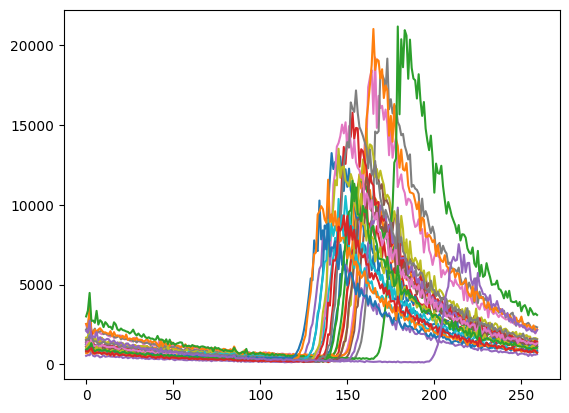

In [10]:
hist = np.sum(img_data, axis=(0,1))
plt.figure()
for i in range(img_data.shape[-1]):
    plt.plot(hist[:, i])

### Realign temporally the histograms of each pixel using the same shift vectors of the IRF

In [11]:
nch = img_data.shape[-1]
dset_shifted = np.empty_like(img_data)
shift_dset = np.zeros( (img_data.ndim - 1, nch) )
shift_dset[-1] = shift_vec
print("shift_dset", shift_dset.shape)

for i in range(nch):
    dset_shifted[..., i] = shift(img_data[..., i], shift_dset[:, i], order = 1, mode='grid-wrap')
    
print("dset_shifted", dset_shifted.shape)

data_3D = dset_shifted.sum(-1)

shift_dset (3, 25)
dset_shifted (300, 300, 260, 25)


(300, 300)


(array([  794.,  5870., 12878., 10687.,  7379.,  5107.,  3809.,  3037.,
         2425.,  1963.,  1597.,  1414.,  1236.,  1092.,   900.,   808.,
          741.,   687.,   612.,   593.,   538.,   525.,   498.,   481.,
          492.,   436.,   458.,   427.,   448.,   441.,   487.,   514.,
          491.,   525.,   503.,   517.,   483.,   520.,   519.,   488.,
          455.,   488.,   522.,   541.,   561.,   573.,   551.,   530.,
          578.,   539.,   549.,   582.,   532.,   512.,   508.,   503.,
          470.,   484.,   434.,   467.,   406.,   421.,   374.,   363.,
          335.,   342.,   291.,   307.,   295.,   268.,   248.,   225.,
          202.,   177.,   164.,   138.,   106.,   112.,   109.,   100.,
           70.,    75.,    76.,    70.,    62.,    57.,    45.,    38.,
           48.,    41.,    29.,    35.,    27.,    30.,    32.,    22.,
           29.,    25.,    22.,    25.]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  

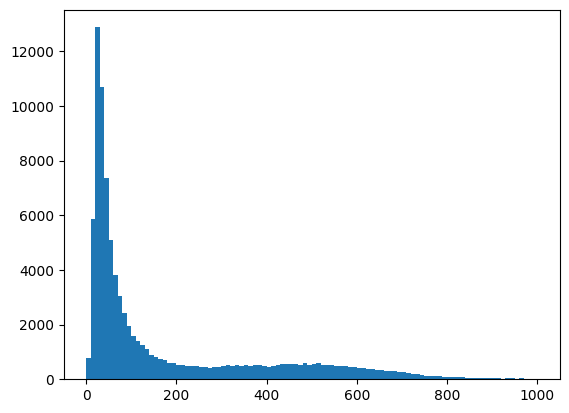

In [12]:
data_2D = np.sum(data_3D, axis=-1)
print(data_2D.shape)
plt.figure()
plt.hist(data_2D.flatten(), bins = 100, range = (0, 1000))

### Phasor plot of the histograms before calibration

(300, 300)


C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\src\brighteyes_flim\flism.py:350: RuntimeWarning: invalid value encountered in divide
  return np.where(flux < threshold, np.nan + 1j * np.nan, transform / flux)


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

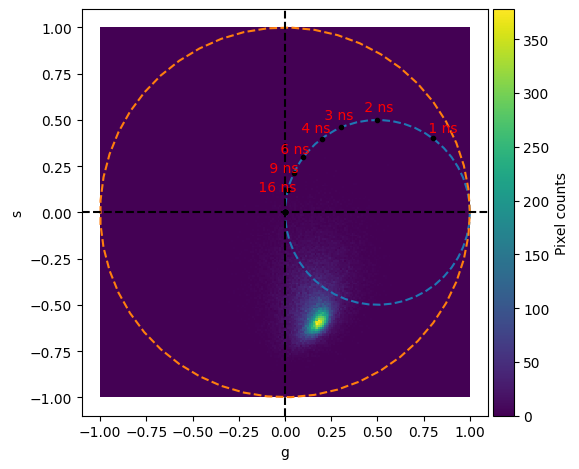

In [13]:
phasor_matrix_1= brighteyes_flim.phasor(data_3D)
print(phasor_matrix_1.shape)
brighteyes_flim.plot_phasor(phasor_matrix_1[:], bins_2dplot=200, log_scale=False, quadrant='all', dfd_freq = 80e6)

### Phasor plot of the histograms after calibration

In [14]:
phasor_irf = brighteyes_flim.phasor(final_irf)
print(phasor_irf)

(-0.37232462670156-0.9156345976687532j)


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

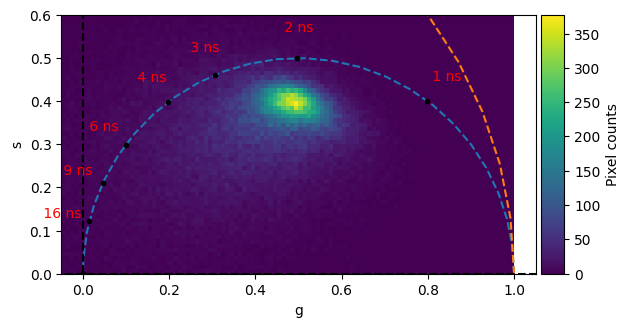

In [15]:
phasor_cleaned = phasor_matrix_1 / phasor_irf
brighteyes_flim.plot_phasor(phasor_cleaned, bins_2dplot=200, log_scale=False, quadrant='first', dfd_freq = 80e6)

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\src\brighteyes_flim\flism.py:411: RuntimeWarning: invalid value encountered in sqrt
  tau_m = np.sqrt((1. / (m ** 2)) - 1) / (2 * np.pi * dfd_freq)


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.100e+01, 2.800e+01,
        3.300e+01, 4.500e+01, 1.030e+02, 2.130e+02, 3.650e+02, 5.990e+02,
        1.028e+03, 1.545e+03, 2.454e+03, 3.737e+03, 5.290e+03, 6.325e+03,
        6.663e+03, 6.093e+03, 5.356e+03, 4.498e+03, 3.751e+03, 3.189e+03,
        2.678e+03, 2.410e+03, 2.194e+03, 2.058e+03, 1.768e+03, 1.651e+03,
        1.538e+03, 1.406e+03, 1.311e+03, 1.180e+03, 1.098e+03, 1.003e+03,
        9.220e+02, 9.350e+02, 7.760e+02, 7.730e+02, 7.490e+02, 6.520e+02,
        6.380e+02, 5.260e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <BarContainer object of 50 artists>)

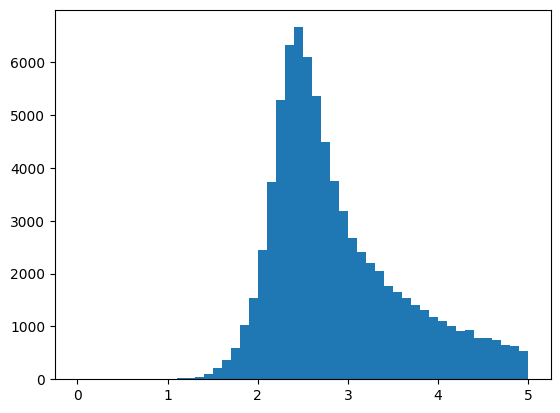

In [16]:
tau_m_clean = brighteyes_flim.calculate_tau_m(phasor_cleaned, dfd_freq = 80e6)
tau_m_data = 1e9*tau_m_clean.flatten()

plt.figure()
plt.hist(tau_m_data, range = (0, 5), bins = 50)

(array([ 194.,  215.,  292.,  399.,  492.,  726.,  981., 1225., 1737.,
        2276., 2969., 3774., 4698., 5995., 6957., 7782., 7587., 6425.,
        5151., 3969., 2846., 2260., 1852., 1477., 1273., 1055.,  889.,
         769.,  692.,  596.,  590.,  514.,  426.,  404.,  357.,  343.,
         300.,  256.,  244.,  222.,  218.,  209.,  171.,  175.,  178.,
         139.,  152.,  136.,  123.,  127.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <BarContainer object of 50 artists>)

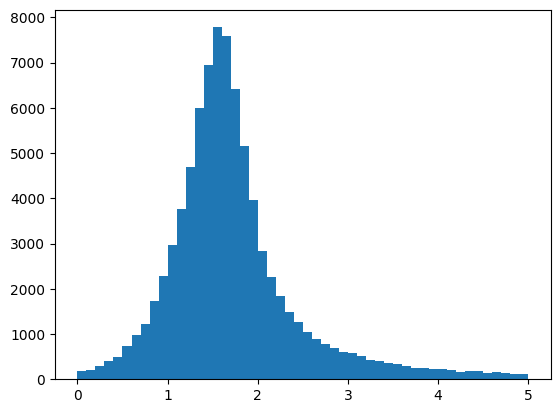

In [17]:
tau_phi = brighteyes_flim.calculate_tau_phi(phasor_cleaned, dfd_freq = 80e6)
tau_data = 1e9*tau_phi.flatten()

plt.figure()
plt.hist(tau_data, range = (0, 5), bins = 50)

[1.44339050e-09 1.31170995e-09 1.78437571e-09 ... 1.96521399e-09
 2.05045901e-09 1.92099055e-09]


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 7.000e+00,
        1.500e+01, 4.700e+01, 1.050e+02, 2.100e+02, 4.020e+02, 7.720e+02,
        1.215e+03, 1.989e+03, 3.035e+03, 4.377e+03, 5.726e+03, 6.383e+03,
        5.820e+03, 4.487e+03, 2.993e+03, 1.884e+03, 1.160e+03, 7.650e+02,
        4.780e+02, 3.410e+02, 2.240e+02, 1.660e+02, 1.210e+02, 8.300e+01,
        6.400e+01, 4.900e+01, 5.800e+01, 3.400e+01, 2.600e+01, 1.300e+01,
        1.100e+01, 8.000e+00, 7.000e+00, 8.000e+00, 8.000e+00, 4.000e+00,
        5.000e+00, 4.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

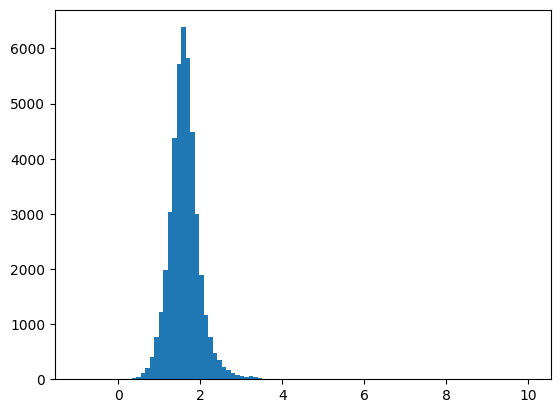

In [18]:
hist_indexes = np.argwhere(data_2D > 70)
tau_phi_denoised = tau_phi[hist_indexes[:, 0], hist_indexes[:, 1]]
print(tau_phi_denoised)
plt.figure()
plt.hist(1e9*tau_phi_denoised, bins = 100, range = (-1, 10))

(43130,)


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 9.000e+00, 4.200e+01, 1.100e+02,
        2.430e+02, 5.130e+02, 9.150e+02, 1.714e+03, 2.941e+03, 4.625e+03,
        5.706e+03, 5.888e+03, 5.003e+03, 4.000e+03, 2.905e+03, 2.074e+03,
        1.498e+03, 1.119e+03, 8.510e+02, 6.730e+02, 4.740e+02, 3.680e+02,
        3.040e+02, 2.400e+02, 1.690e+02, 1.470e+02, 1.100e+02, 8.900e+01,
        7.600e+01, 5.900e+01, 4.800e+01, 4.200e+01, 2.700e+01, 3.100e+01,
        1.700e+01, 6.000e+00, 1.400e+01, 9.000e+00, 1.400e+01, 1.000e+01,
        1.000e+01, 8.000e+00, 2.000e+00, 3.000e+00, 5.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

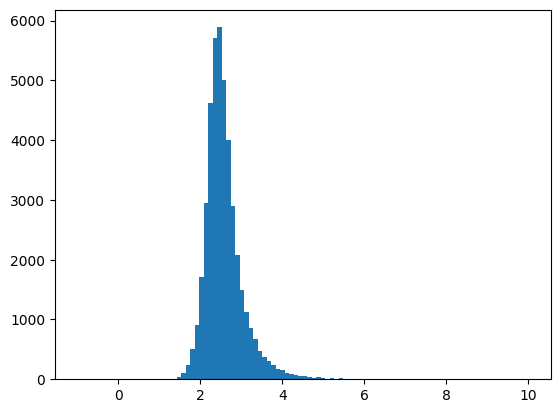

In [19]:
tau_m_denoised = tau_m_clean[hist_indexes[:, 0], hist_indexes[:, 1]]
print(tau_m_denoised.shape)
plt.figure()
plt.hist(1e9*tau_m_denoised, bins = 100, range = (-1, 10))

### APR processing

In [20]:
import brighteyes_ism.analysis.APR_lib as apr
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
from tqdm import tqdm

(300, 300, 260, 25)
(300, 300, 25)


C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:548: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(shift[:, 0], shift[:, 1], s=80, c=color, edgecolors='black', cmap=cmap)


[[ 1.14  0.59]
 [ 1.04  0.19]
 [ 0.87 -0.28]
 [ 0.68 -0.67]
 [ 0.51 -1.02]
 [ 0.72  0.71]
 [ 0.59  0.29]
 [ 0.36 -0.13]
 [ 0.27 -0.52]
 [ 0.1  -0.9 ]
 [ 0.37  0.82]
 [ 0.15  0.36]
 [ 0.    0.  ]
 [-0.14 -0.36]
 [-0.27 -0.76]
 [-0.03  1.07]
 [-0.24  0.6 ]
 [-0.3   0.14]
 [-0.55 -0.29]
 [-0.74 -0.7 ]
 [-0.47  1.28]
 [-0.64  0.85]
 [-0.8   0.39]
 [-0.99 -0.08]
 [-1.13 -0.55]]


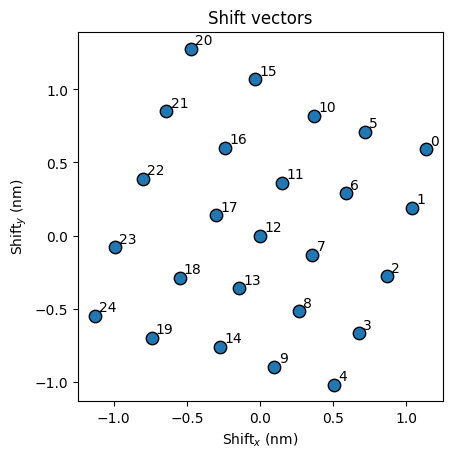

In [21]:
print(dset_shifted.shape)
image_3d = np.sum(dset_shifted, axis = -2)
print(image_3d.shape)
shift_vectors, err = apr.ShiftVectors(image_3d, usf = 100, ref = 12)
gr.PlotShiftVectors(shift_vectors)
print (shift_vectors)     

In [23]:
with h5py.File(r"C:\Users\fdelbufalo\Desktop\images\Convallaria_29_luglio_2024\APR_Convallaria_500us", 'w') as f:
     x_size, y_size, bin_size, channel_size = dset_shifted.shape[0], dset_shifted.shape[1], dset_shifted.shape[2], dset_shifted.shape[3]
# Create an empty dataset with dimensions (x,y,t, ch)

     dataset_shape = (x_size, y_size, bin_size, channel_size)
     h5_dataset = f.create_dataset('data', shape=dataset_shape, dtype=np.uint64)
    

     for bin in tqdm(range(dset_shifted.shape[-2])):
         h5_dataset[:, :, bin, :] = apr.Reassignment(shift_vectors, dset_shifted[:, :, bin, :], mode = 'interp')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260/260 [07:25<00:00,  1.72s/it]


In [22]:
f = h5py.File(r"C:\Users\fdelbufalo\Desktop\images\Convallaria_29_luglio_2024\APR_Convallaria_500us", 'r')
h5_dataset = f["data"]
print(h5_dataset.shape)

(300, 300, 260, 25)


In [23]:
h5_dataset_sum = np.sum(h5_dataset, axis=-1)

(300, 300)


(array([  237.,  4443., 12307., 10805.,  7930.,  5643.,  4080.,  3092.,
         2505.,  2103.,  1741.,  1492.,  1317.,  1166.,   973.,   856.,
          820.,   659.,   629.,   621.,   549.,   467.,   483.,   436.,
          427.,   454.,   447.,   396.,   378.,   419.,   441.,   441.,
          457.,   487.,   429.,   448.,   460.,   445.,   442.,   460.,
          447.,   444.,   450.,   443.,   477.,   446.,   512.,   470.,
          489.,   490.,   581.,   537.,   503.,   505.,   459.,   504.,
          508.,   513.,   458.,   446.,   476.,   441.,   434.,   416.,
          466.,   391.,   382.,   362.,   323.,   336.,   308.,   311.,
          265.,   267.,   261.,   245.,   213.,   177.,   163.,   157.,
          153.,   123.,   121.,   107.,    84.,    61.,    61.,    57.,
           58.,    60.,    36.,    40.,    37.,    40.,    42.,    38.,
           27.,    28.,    36.,    28.]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  

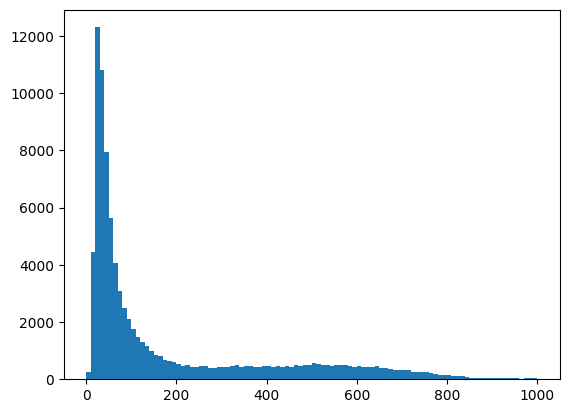

In [24]:
data_histograms = np.sum(h5_dataset_sum, axis = -1)
print(data_histograms.shape)
    
# Plot the histogram of the photon counts in each pixel to see the distribution (e.g. check the level of noise) 
plt.figure()
plt.hist(data_histograms.flatten(), bins = 100, range = (0, 1000))

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

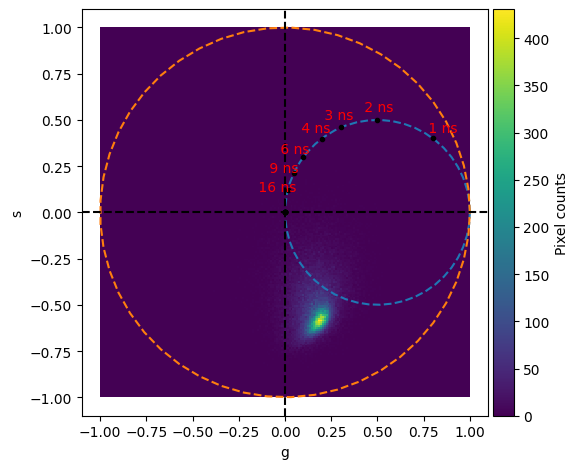

In [25]:
phasors_unc = brighteyes_flim.phasor(h5_dataset_sum)
brighteyes_flim.plot_phasor(phasors_unc, bins_2dplot=200, log_scale=False, quadrant='all', dfd_freq = 80e6)

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

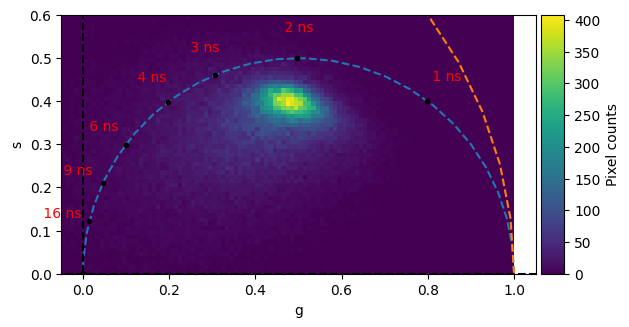

In [26]:
phasors_pix_apr = phasors_unc / phasor_irf
brighteyes_flim.plot_phasor(phasors_pix_apr, bins_2dplot=200, log_scale=False, quadrant='first', dfd_freq = 80e6)

In [27]:
tau_phi_apr = brighteyes_flim.calculate_tau_phi(phasors_pix_apr, dfd_freq = 80e6)
print(tau_phi_apr)

[[ 1.84852869e-09 -1.31045448e-09  1.98569553e-09 ...  1.32134901e-09
   2.65010809e-09  1.35959990e-09]
 [ 6.91933704e-10  1.45931983e-09  2.76849449e-09 ...  1.54455913e-09
   1.44106449e-09  1.37924194e-09]
 [ 1.40991392e-09 -1.12244770e-08  4.96514264e-10 ...  1.55681301e-09
   1.47556592e-09  1.36999584e-09]
 ...
 [ 7.15878194e-09  7.82622492e-09  3.27441279e-10 ...  2.31976358e-09
   1.64714133e-09  1.94139131e-09]
 [-3.16308336e-09  2.23132423e-09  1.79762602e-09 ...  2.07401956e-09
   1.84168744e-09  1.93731936e-09]
 [ 1.55795255e-09  1.57503190e-09  3.42416037e-09 ...  2.29259908e-09
   2.08412710e-09  2.26959905e-09]]


In [28]:
tau_m_apr = brighteyes_flim.calculate_tau_m(phasors_pix_apr, dfd_freq = 80e6)
print(tau_m_apr)

[[8.13553486e-08 6.46482956e-10 1.37903686e-09 ... 1.56641075e-09
  3.68296227e-09 1.30819822e-09]
 [1.29071740e-08 4.74034308e-09 2.19036622e-09 ... 2.17149385e-09
  2.02333155e-09 2.42729133e-09]
 [4.45599927e-09 9.47418258e-09 5.18087381e-09 ... 2.05535497e-09
  2.18180517e-09 2.00666869e-09]
 ...
 [5.43710977e-09 2.54486438e-09 2.40555087e-09 ... 2.81719633e-09
  2.28166802e-09 2.70089823e-09]
 [1.89698137e-09 2.94102392e-09 8.55757622e-09 ... 2.81421136e-09
  4.78606533e-09 4.16844209e-09]
 [3.60781255e-09 5.56597669e-09 7.50882756e-09 ... 3.33450786e-09
  8.10240929e-09 5.42959108e-09]]


(array([   45.,    32.,    36.,    47.,    49.,    58.,    59.,    58.,
           54.,    63.,    93.,   126.,   200.,   252.,   445.,   829.,
         1737.,  3553.,  6472., 11009., 16570., 16164.,  9711.,  5225.,
         3159.,  2204.,  1618.,  1231.,   953.,   726.,   651.,   550.,
          417.,   373.,   338.,   247.,   236.,   212.,   170.,   184.,
          150.,   128.,   112.,   119.,    74.,   100.,    87.,    66.,
           59.,    69.]),
 array([-3.  , -2.78, -2.56, -2.34, -2.12, -1.9 , -1.68, -1.46, -1.24,
        -1.02, -0.8 , -0.58, -0.36, -0.14,  0.08,  0.3 ,  0.52,  0.74,
         0.96,  1.18,  1.4 ,  1.62,  1.84,  2.06,  2.28,  2.5 ,  2.72,
         2.94,  3.16,  3.38,  3.6 ,  3.82,  4.04,  4.26,  4.48,  4.7 ,
         4.92,  5.14,  5.36,  5.58,  5.8 ,  6.02,  6.24,  6.46,  6.68,
         6.9 ,  7.12,  7.34,  7.56,  7.78,  8.  ]),
 <BarContainer object of 50 artists>)

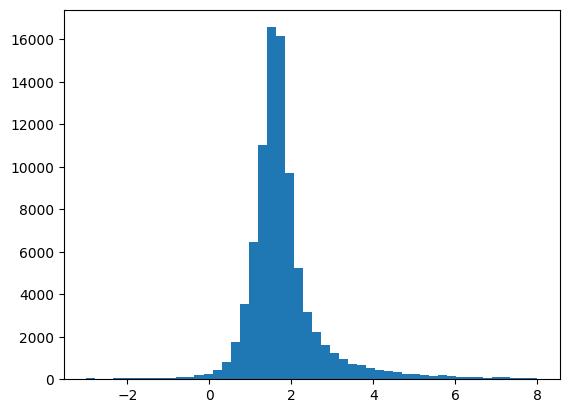

In [29]:
tau_data_apr = 1e9*tau_phi_apr.flatten()

plt.figure()
plt.hist(tau_data_apr, range = (-3, 8), bins = 50)

(array([0.0000e+00, 1.0000e+00, 1.0000e+01, 8.0000e+00, 4.5000e+01,
        2.0700e+02, 9.2900e+02, 3.5710e+03, 1.0998e+04, 1.7406e+04,
        1.3173e+04, 8.4410e+03, 6.0040e+03, 4.5830e+03, 3.7730e+03,
        3.0760e+03, 2.5460e+03, 2.0870e+03, 1.6800e+03, 1.3560e+03,
        1.2060e+03, 1.0360e+03, 8.2500e+02, 7.1800e+02, 6.1000e+02,
        5.4600e+02, 4.6900e+02, 4.1000e+02, 3.7800e+02, 3.0700e+02,
        3.0600e+02, 2.3000e+02, 2.0900e+02, 1.9800e+02, 1.8700e+02,
        1.5700e+02, 1.6300e+02, 1.3100e+02, 1.2400e+02, 1.2000e+02,
        1.1100e+02, 1.0100e+02, 7.9000e+01, 6.9000e+01, 7.3000e+01,
        5.6000e+01, 4.3000e+01, 4.7000e+01, 5.0000e+01, 4.3000e+01]),
 array([ 0.  ,  0.26,  0.52,  0.78,  1.04,  1.3 ,  1.56,  1.82,  2.08,
         2.34,  2.6 ,  2.86,  3.12,  3.38,  3.64,  3.9 ,  4.16,  4.42,
         4.68,  4.94,  5.2 ,  5.46,  5.72,  5.98,  6.24,  6.5 ,  6.76,
         7.02,  7.28,  7.54,  7.8 ,  8.06,  8.32,  8.58,  8.84,  9.1 ,
         9.36,  9.62,  9.88, 10.14

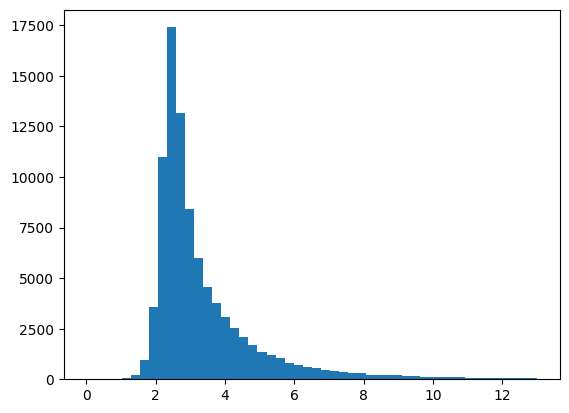

In [30]:
tau_m_data_apr = 1e9*tau_m_apr.flatten()

plt.figure()
plt.hist(tau_m_data_apr, range = (0, 13), bins = 50)

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:660: RuntimeWarning: invalid value encountered in cast
  idx = (np.floor((variable - self.var_bounds[0]) / (self.var_bounds[1] - self.var_bounds[0]) * N)).astype(int)


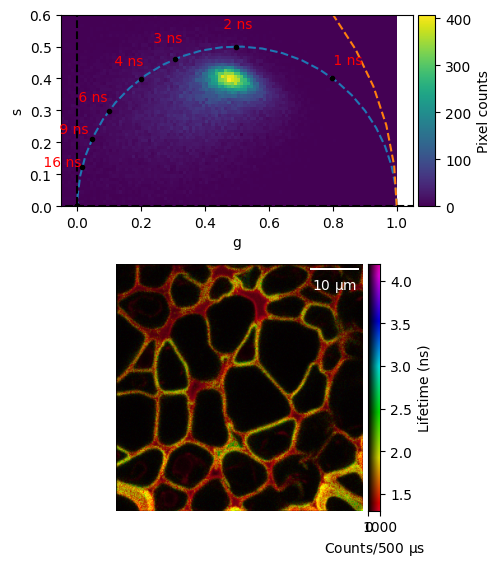

In [31]:
fig = plt.figure(figsize = (9, 6))
gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[2:4, 0:2])
brighteyes_flim.plot_phasor(phasors_pix_apr[:], bins_2dplot=200, log_scale=False, quadrant='first', fig = fig, ax = ax1, dfd_freq = 80e6)
gr.show_flim(data_histograms, tau_phi_apr*1e9, pxsize = 0.167, pxdwelltime = 500, lifetime_bounds = (1.3, 4.2), intensity_bounds = (0, 1000), fig = fig, ax = ax2)  
fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\APR_convallaria_29_07.pdf", dpi = 900)

### CALCULATE THE LIFETIME WITH THE FITTING (Confocal case)

### Check the global histogram (sum of the decay histograms of each pixel)

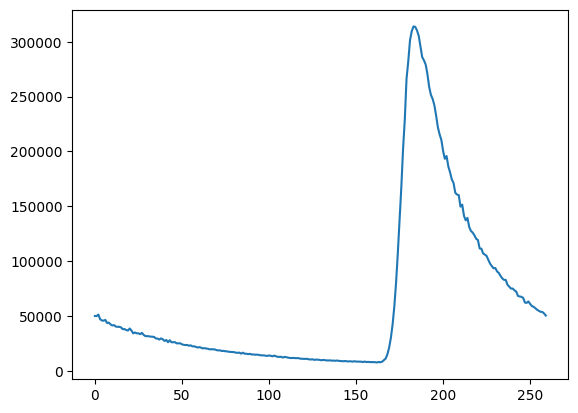

In [32]:
hist_conv = np.sum(data_3D, axis = (0,1))
plt.figure()
plt.plot(hist_conv)

### Define the model

In [33]:
def exp_fun(A, tau, t):
    decay = A * np.exp(-t/tau) 
   # decay[t<0] = 0
    return decay

def model_2(t, A, tau, bkg):
   
    dt = 0.048 #ns
    nbin = 260 
    period = dt * nbin
    
    irf = final_irf.copy().astype(np.float64)
    irf/= irf.sum()
    decay = (np.heaviside(t, 0) + 1/(np.exp(period/tau) -1)) * exp_fun(A,tau,t)
    decay_convolved = scipy.signal.convolve(decay, irf, mode='same')
    decay_convolved =  decay_convolved[nbin//2:-nbin//2]
    return decay_convolved + bkg

In [34]:
def fit_function_2(t, A, tau, bkg):
    return model_2(t, A, tau, bkg)

### find the maximum of the histogram generated by the model 

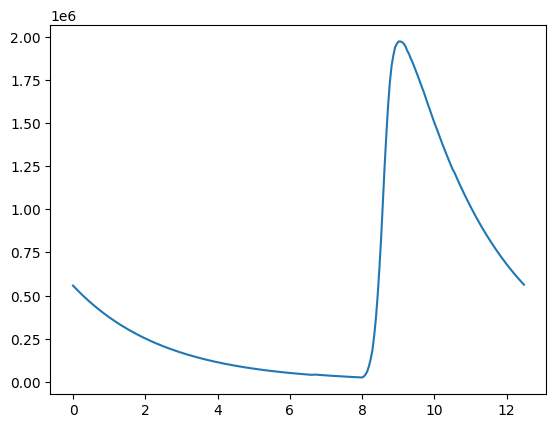

In [35]:
dt = 0.048 #ns
nbin = 260 
period = dt * nbin
t=np.linspace(-period, period, nbin*2)
t_1 = np.linspace(0, period, nbin) 

decay = (np.heaviside(t, 0) + 1/(np.exp(period/2.5) -1)) * exp_fun(10,2.5,t)
decay_convolved = scipy.signal.convolve(decay, final_irf, mode='same')
decay_convolved =  decay_convolved[nbin//2:-nbin//2]

plt.figure()
plt.plot(t_1, decay_convolved)

In [36]:
print(np.argmax(decay_convolved))
print(np.argmax(final_irf))
print(np.argmax(hist_conv))

187
178
183


### Get the decay histogram of each pixel, apply the fitting model and extract the lifetime estimated for each pixel (then save it in a 2D matrix)

In [37]:
hist_shifted = shift(hist_conv, 3.1, order=1, mode='grid-wrap')
print(np.argmax(hist_shifted))

187


### test on the global fitting

In [38]:
dt = 0.048 #ns
nbin = 260 
per = dt*nbin
t_axis = np.linspace(-per, per, nbin*2)
initial_guess = [450000, 2.5, 2000]


# Perform the fit
popt, pcov = scipy.optimize.curve_fit(fit_function_2, t_axis, hist_shifted, p0=initial_guess)

# Extract fitted parameters
fitted_A, fitted_tau, fitted_bkg  = popt

In [39]:
print(f"Fitted parameters: A = {fitted_A}, tau = {fitted_tau}, Background noise = {fitted_bkg}")

Fitted parameters: A = 393999.8670041611, tau = 1.6514056635504388, Background noise = 10902.025054911175


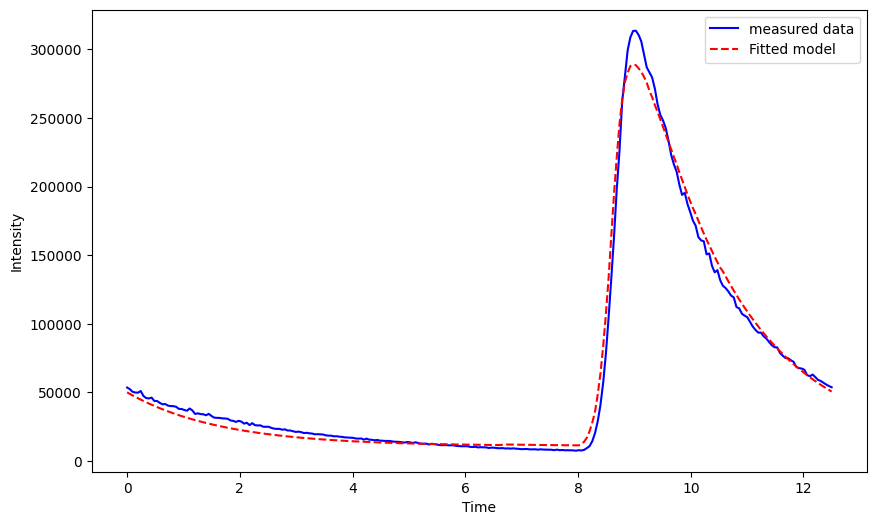

In [40]:
t = np.linspace(0, 12.5, 260)
plt.figure(figsize=(10, 6))
plt.plot(t, hist_shifted, 'b-', label='measured data')
plt.plot(t, fit_function_2(t_axis, *popt), 'r--', label='Fitted model')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

### reconstruct the lifetime in each pixel

In [41]:
lifetime_map = np.zeros((data_3D.shape[0], data_3D.shape[1]))
background_map = np.zeros((data_3D.shape[0], data_3D.shape[1]))
initial_guess = [10000, 2.5, 500]
dt = 0.048 #ns
nbin = 260 
per = dt*nbin
t_axis = np.linspace(-per, per, nbin*2)

for i in range(data_3D.shape[0]):
    for j in range(data_3D.shape[1]):
       
        decay_histogram = data_3D[i, j, :]
        decay_histogram = shift(decay_histogram, 3.1, order=1, mode='grid-wrap')
        
        try:
            popt, pcov = scipy.optimize.curve_fit(fit_function_2, t_axis, decay_histogram, p0=initial_guess)
            fitted_tau = popt[1]
            fitted_bkg = popt[2]
        
        except RuntimeError:
            fitted_tau = np.nan
        
        
        lifetime_map[i, j] = fitted_tau
        background_map[i, j] = fitted_bkg


C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_7568\938643683.py:2: RuntimeWarning: overflow encountered in exp
  decay = A * np.exp(-t/tau)
C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_7568\938643683.py:2: RuntimeWarning: overflow encountered in multiply
  decay = A * np.exp(-t/tau)
C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_7568\938643683.py:14: RuntimeWarning: invalid value encountered in multiply
  decay = (np.heaviside(t, 0) + 1/(np.exp(period/tau) -1)) * exp_fun(A,tau,t)
C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_7568\938643683.py:14: RuntimeWarning: overflow encountered in exp
  decay = (np.heaviside(t, 0) + 1/(np.exp(period/tau) -1)) * exp_fun(A,tau,t)
C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_7568\3366931042.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_function_2, t_axis, decay_histogram, p0=initial_guess)


In [42]:
print(lifetime_map.shape)

(300, 300)


### Compare the distributions of lifetime in each pixel with the tbree methods considered to calculate tau:
### 1. Fitting
### 2. Tau_phi
### 3. Tau_m

(array([   39.,    33.,    28.,    43.,    32.,    47.,    46.,    64.,
           67.,    73.,    76.,    97.,   134.,  1717.,   717.,  1443.,
         2624.,  4501.,  6718.,  9606., 12511., 12606.,  9430.,  5942.,
         4319.,  2509.,  1777.,  1434.,  1137.,   899.,   794.,   639.,
          516.,   446.,   379.,   331.,   276.,   243.,   212.,   184.,
          167.,   125.,   144.,   144.,   125.,   119.,   120.,    76.,
          100.,    94.]),
 array([-3.  , -2.78, -2.56, -2.34, -2.12, -1.9 , -1.68, -1.46, -1.24,
        -1.02, -0.8 , -0.58, -0.36, -0.14,  0.08,  0.3 ,  0.52,  0.74,
         0.96,  1.18,  1.4 ,  1.62,  1.84,  2.06,  2.28,  2.5 ,  2.72,
         2.94,  3.16,  3.38,  3.6 ,  3.82,  4.04,  4.26,  4.48,  4.7 ,
         4.92,  5.14,  5.36,  5.58,  5.8 ,  6.02,  6.24,  6.46,  6.68,
         6.9 ,  7.12,  7.34,  7.56,  7.78,  8.  ]),
 <BarContainer object of 50 artists>)

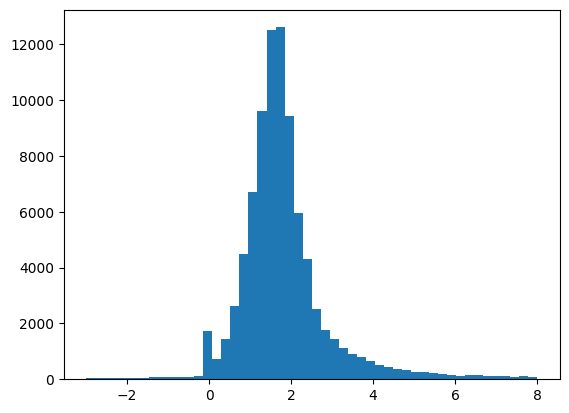

In [43]:
plt.figure()
lifetime_flattened = lifetime_map.flatten()
plt.hist(lifetime_flattened, range = (-3, 8), bins = 50)

[1.29505609 1.54322941 2.34359984 ... 2.22034298 2.11501578 1.84320982]


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.290e+02, 0.000e+00, 5.000e+00, 1.700e+01,
        6.200e+01, 1.530e+02, 2.550e+02, 4.370e+02, 7.850e+02, 1.030e+03,
        1.406e+03, 2.048e+03, 2.660e+03, 3.506e+03, 4.267e+03, 4.735e+03,
        4.718e+03, 4.340e+03, 3.540e+03, 2.674e+03, 1.864e+03, 1.282e+03,
        8.720e+02, 5.820e+02, 4.580e+02, 2.900e+02, 2.310e+02, 1.450e+02,
        1.260e+02, 1.070e+02, 8.500e+01, 7.000e+01, 3.100e+01, 3.000e+01,
        3.800e+01, 2.600e+01, 2.400e+01, 2.000e+01, 1.600e+01, 9.000e+00,
        5.000e+00, 6.000e+00, 7.000e+00, 3.000e+00, 6.000e+00, 1.000e+00,
        2.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

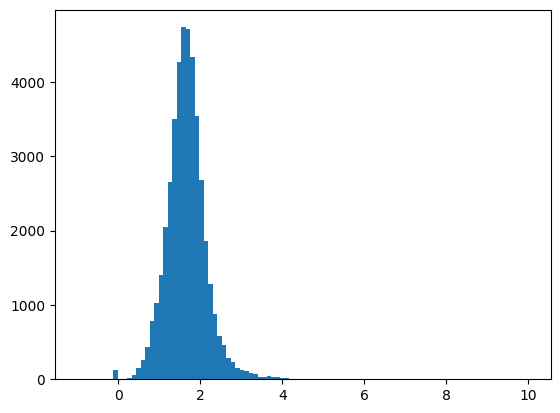

In [44]:
tau_fitting_denoised = lifetime_map[hist_indexes[:, 0], hist_indexes[:, 1]]
print(tau_fitting_denoised)
plt.figure()
plt.hist(tau_fitting_denoised, bins = 100, range = (-1, 10))

[1.44339050e-09 1.31170995e-09 1.78437571e-09 ... 1.96521399e-09
 2.05045901e-09 1.92099055e-09]


(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00,
        5.1000e+01, 2.9200e+02, 1.0470e+03, 2.9660e+03, 6.9650e+03,
        1.1827e+04, 1.0733e+04, 5.3210e+03, 2.0420e+03, 9.1200e+02,
        4.0900e+02, 2.2600e+02, 1.1200e+02, 9.6000e+01, 4.4000e+01,
        1.9000e+01, 1.7000e+01, 1.1000e+01, 1.0000e+01, 5.0000e+00,
        4.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]),
 array([-3.  , -2.78, -2.56, -2.34, -2.12, -1.9 , -1.68, -1.46, -1.24,
        -1.02, -0.8 , -0.58, -0.36, -0.14,  0.08,  0.3 ,  0.52,  0.74,
         0.96,  1.18,  1.4 ,  1.62,  1.84,  2.06,  2.28,  2.5 ,  2.72,
         2.94,  3.16,  3.38,  3.6 ,  3.82,  4.04,  4.26,  4.48,  4.7 ,
         4.92,  5.14,  5.36,  5.58

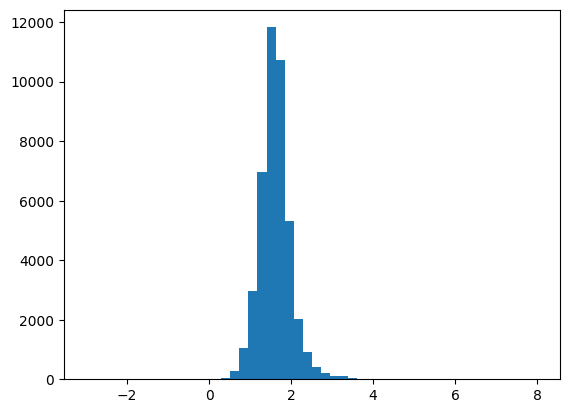

In [120]:
tau_phi_denoised = tau_phi[hist_indexes[:, 0], hist_indexes[:, 1]]
print(tau_phi_denoised)
plt.figure()
plt.hist(1e9*tau_phi_denoised, bins = 50, range = (-3, 8))

(array([   20.,    18.,    21.,    27.,    24.,    23.,    27.,    33.,
           56.,    50.,    48.,    84.,   107.,  1414.,   665.,  1347.,
         2528.,  4267.,  6629.,  9233., 12567., 13240., 10452.,  6442.,
         4012.,  2641.,  1874.,  1489.,  1091.,   934.,   716.,   617.,
          523.,   422.,   380.,   344.,   304.,   256.,   229.,   195.,
          176.,   156.,   141.,   154.,   109.,   111.,   102.,    98.,
           85.,    80.]),
 array([-3.  , -2.78, -2.56, -2.34, -2.12, -1.9 , -1.68, -1.46, -1.24,
        -1.02, -0.8 , -0.58, -0.36, -0.14,  0.08,  0.3 ,  0.52,  0.74,
         0.96,  1.18,  1.4 ,  1.62,  1.84,  2.06,  2.28,  2.5 ,  2.72,
         2.94,  3.16,  3.38,  3.6 ,  3.82,  4.04,  4.26,  4.48,  4.7 ,
         4.92,  5.14,  5.36,  5.58,  5.8 ,  6.02,  6.24,  6.46,  6.68,
         6.9 ,  7.12,  7.34,  7.56,  7.78,  8.  ]),
 <BarContainer object of 50 artists>)

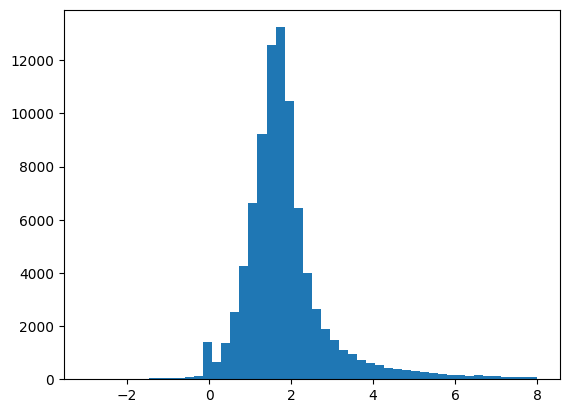

In [119]:
plt.figure()
plt.hist(lifetime_flattened_apr, range = (-3, 8), bins = 50)

(43130,)


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 9.000e+00, 4.200e+01, 1.100e+02,
        2.430e+02, 5.130e+02, 9.150e+02, 1.714e+03, 2.941e+03, 4.625e+03,
        5.706e+03, 5.888e+03, 5.003e+03, 4.000e+03, 2.905e+03, 2.074e+03,
        1.498e+03, 1.119e+03, 8.510e+02, 6.730e+02, 4.740e+02, 3.680e+02,
        3.040e+02, 2.400e+02, 1.690e+02, 1.470e+02, 1.100e+02, 8.900e+01,
        7.600e+01, 5.900e+01, 4.800e+01, 4.200e+01, 2.700e+01, 3.100e+01,
        1.700e+01, 6.000e+00, 1.400e+01, 9.000e+00, 1.400e+01, 1.000e+01,
        1.000e+01, 8.000e+00, 2.000e+00, 3.000e+00, 5.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

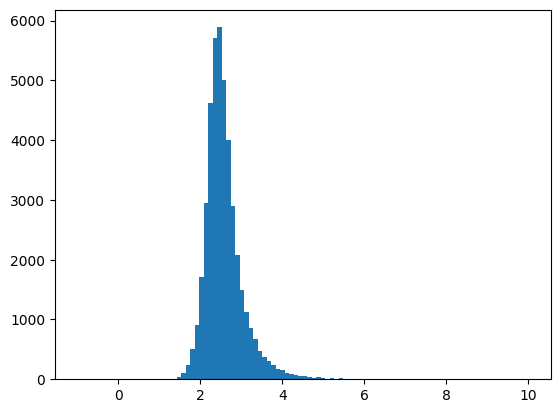

In [46]:
tau_m_denoised = tau_m_clean[hist_indexes[:, 0], hist_indexes[:, 1]]
print(tau_m_denoised.shape)
plt.figure()
plt.hist(1e9*tau_m_denoised, bins = 100, range = (-1, 10))

### Compare the lifetime images obtained with the three considered methods for the confocal case
### 1. Fitting
### 2. Tau_phi
### 3. Tau_m

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:660: RuntimeWarning: invalid value encountered in cast
  idx = (np.floor((variable - self.var_bounds[0]) / (self.var_bounds[1] - self.var_bounds[0]) * N)).astype(int)


<Figure size 900x600 with 0 Axes>

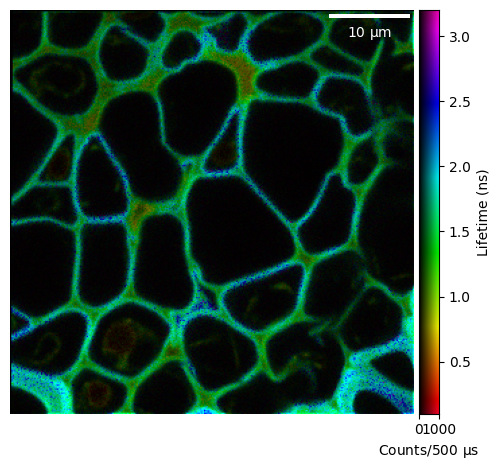

In [122]:
fig = plt.figure(figsize = (9, 6))
gr.show_flim(data_2D, lifetime_map, pxsize = 0.167, pxdwelltime = 500, lifetime_bounds = (0.1, 3.2), intensity_bounds = (0, 1000), fig = fig)  
fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\Fitting_convallaria_29_07.pdf", dpi = 900)

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:660: RuntimeWarning: invalid value encountered in cast
  idx = (np.floor((variable - self.var_bounds[0]) / (self.var_bounds[1] - self.var_bounds[0]) * N)).astype(int)


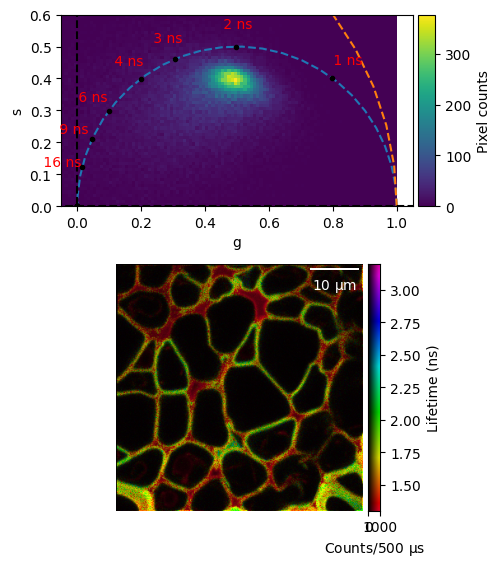

In [48]:
fig = plt.figure(figsize = (9, 6))
gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[2:4, 0:2])
brighteyes_flim.plot_phasor(phasor_cleaned, bins_2dplot=200, log_scale=False, quadrant='first', fig = fig, ax = ax1, dfd_freq = 80e6)
gr.show_flim(data_2D, tau_phi*1e9, pxsize = 0.167, pxdwelltime = 500, lifetime_bounds = (1.3, 3.2), intensity_bounds = (0, 1000), fig = fig, ax = ax2)  
fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\Tau_phi_convallaria_29_07.pdf", dpi = 900)

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:660: RuntimeWarning: invalid value encountered in cast
  idx = (np.floor((variable - self.var_bounds[0]) / (self.var_bounds[1] - self.var_bounds[0]) * N)).astype(int)


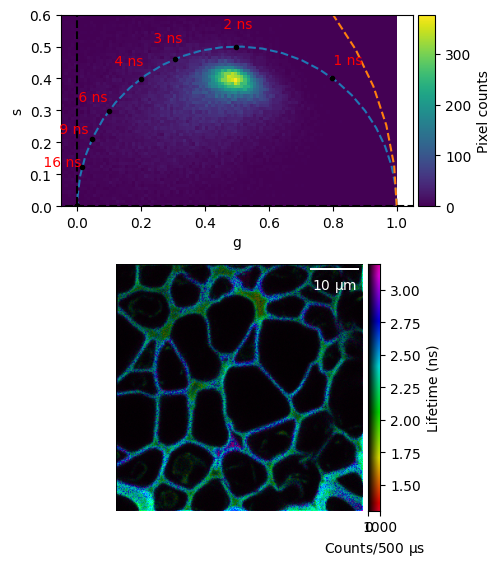

In [49]:
fig = plt.figure(figsize = (9, 6))
gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[2:4, 0:2])
brighteyes_flim.plot_phasor(phasor_cleaned, bins_2dplot=200, log_scale=False, quadrant='first', fig = fig, ax = ax1, dfd_freq = 80e6)
gr.show_flim(data_2D, tau_m_clean*1e9, pxsize = 0.167, pxdwelltime = 500, lifetime_bounds = (1.3, 3.2), intensity_bounds = (0, 1000), fig = fig, ax = ax2)  
fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\Tau_m_convallaria_29_07.pdf", dpi = 900)

### CALCULATE LIFETIME WITH FITTING (APR case)

### test on global histogram

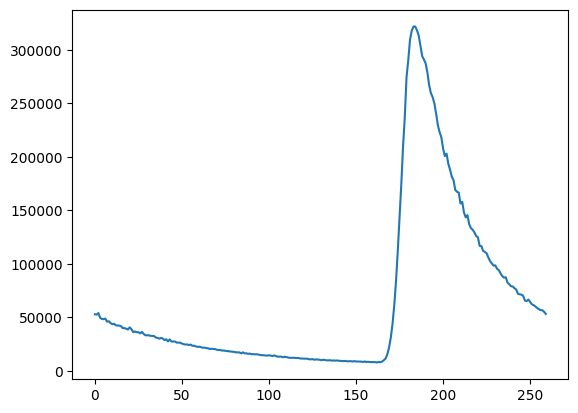

In [50]:
global_hist = np.sum(h5_dataset_sum, axis=(0,1))
plt.figure()
plt.plot(global_hist)

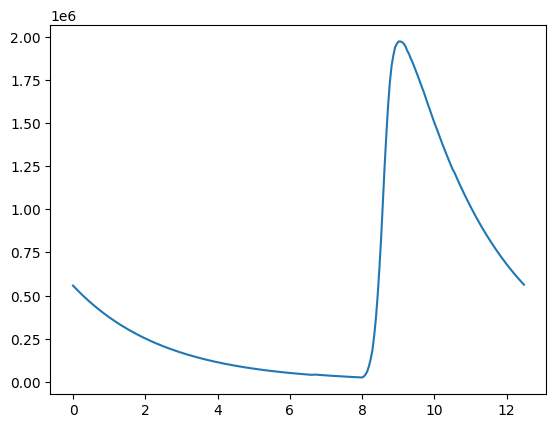

In [51]:
dt = 0.048 #ns
nbin = 260 
period = dt * nbin
t=np.linspace(-period, period, nbin*2)
t_1 = np.linspace(0, period, nbin) 

decay = (np.heaviside(t, 0) + 1/(np.exp(period/2.5) -1)) * exp_fun(10,2.5,t)
decay_convolved = scipy.signal.convolve(decay, final_irf, mode='same')
decay_convolved =  decay_convolved[nbin//2:-nbin//2]

plt.figure()
plt.plot(t_1, decay_convolved)

In [52]:
print(np.argmax(global_hist))
print(np.argmax(final_irf))
print(np.argmax(hist_conv))

183
178
183


In [57]:
global_hist_shifted = shift(global_hist, 0.1, order=1, mode='grid-wrap')
print(np.argmax(global_hist_shifted))

184


In [58]:
dt_g = 0.048 #ns
nbin_g = 260 
per_g = dt*nbin
t_axis_g = np.linspace(-per_g, per_g, nbin_g*2)
initial_guess_g = [300000, 2.3, 2000]


# Perform the fit
popt_g, pcov_g = scipy.optimize.curve_fit(fit_function_2, t_axis_g, global_hist_shifted, p0=initial_guess_g)

# Extract fitted parameters
fitted_A_g, fitted_tau_g, fitted_bkg_g  = popt_g

In [59]:
print(f"Fitted parameters: A = {fitted_A_g}, tau = {fitted_tau_g}, Background noise = {fitted_bkg_g}")

Fitted parameters: A = 446858.8950705904, tau = 1.306438274870109, Background noise = 18859.56513845015


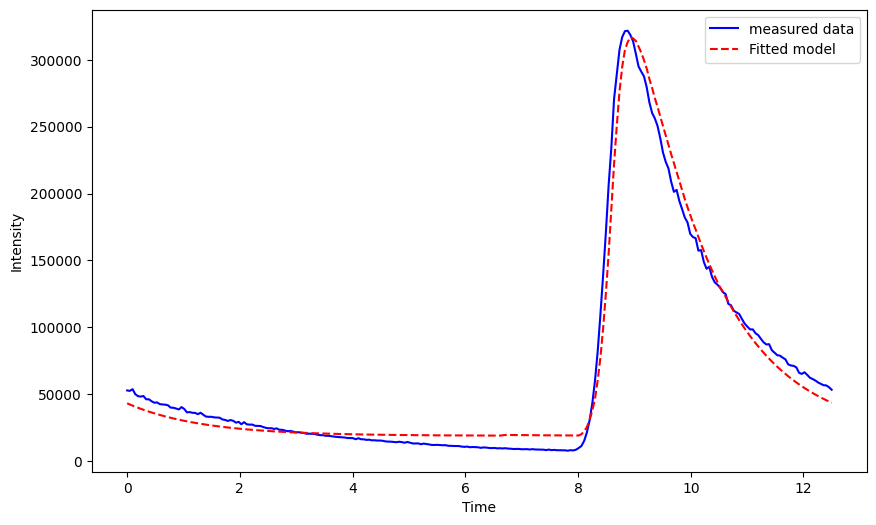

In [60]:
t = np.linspace(0, 12.5, 260)
plt.figure(figsize=(10, 6))
plt.plot(t, global_hist_shifted, 'b-', label='measured data')
plt.plot(t, fit_function_2(t_axis_g, *popt_g), 'r--', label='Fitted model')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

### Reconstruct the lifetime in each pixel (APR dataset)

In [61]:
lifetime_map_apr = np.zeros((h5_dataset_sum.shape[0], h5_dataset_sum.shape[1]))
initial_guess_apr = [1000, 2.5, 50]
dt = 0.048 #ns
nbin = 260 
per = dt*nbin
t_axis = np.linspace(-per, per, nbin*2)

for i in range(h5_dataset_sum.shape[0]):
    for j in range(h5_dataset_sum.shape[1]):
       
        decay_histogram_apr = h5_dataset_sum[i, j, :]
        decay_histogram_apr = shift(decay_histogram_apr, 3.1, order=1, mode='grid-wrap')
        
        try:
            popt, pcov = scipy.optimize.curve_fit(fit_function_2, t_axis, decay_histogram_apr, p0=initial_guess_apr)
            fitted_tau_apr = popt[1]
            
        except RuntimeError:
            fitted_tau_apr = np.nan
        
        
        lifetime_map_apr[i, j] = fitted_tau_apr

C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_7568\938643683.py:14: RuntimeWarning: overflow encountered in exp
  decay = (np.heaviside(t, 0) + 1/(np.exp(period/tau) -1)) * exp_fun(A,tau,t)
C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_7568\938643683.py:2: RuntimeWarning: overflow encountered in exp
  decay = A * np.exp(-t/tau)
C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_7568\938643683.py:14: RuntimeWarning: invalid value encountered in multiply
  decay = (np.heaviside(t, 0) + 1/(np.exp(period/tau) -1)) * exp_fun(A,tau,t)
C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_7568\938643683.py:2: RuntimeWarning: overflow encountered in multiply
  decay = A * np.exp(-t/tau)
C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_7568\3102168534.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_function_2, t_axis, decay_histogram_apr, p0=initial_guess_apr)


(array([   20.,    18.,    21.,    27.,    24.,    23.,    27.,    33.,
           56.,    50.,    48.,    84.,   107.,  1414.,   665.,  1347.,
         2528.,  4267.,  6629.,  9233., 12567., 13240., 10452.,  6442.,
         4012.,  2641.,  1874.,  1489.,  1091.,   934.,   716.,   617.,
          523.,   422.,   380.,   344.,   304.,   256.,   229.,   195.,
          176.,   156.,   141.,   154.,   109.,   111.,   102.,    98.,
           85.,    80.]),
 array([-3.  , -2.78, -2.56, -2.34, -2.12, -1.9 , -1.68, -1.46, -1.24,
        -1.02, -0.8 , -0.58, -0.36, -0.14,  0.08,  0.3 ,  0.52,  0.74,
         0.96,  1.18,  1.4 ,  1.62,  1.84,  2.06,  2.28,  2.5 ,  2.72,
         2.94,  3.16,  3.38,  3.6 ,  3.82,  4.04,  4.26,  4.48,  4.7 ,
         4.92,  5.14,  5.36,  5.58,  5.8 ,  6.02,  6.24,  6.46,  6.68,
         6.9 ,  7.12,  7.34,  7.56,  7.78,  8.  ]),
 <BarContainer object of 50 artists>)

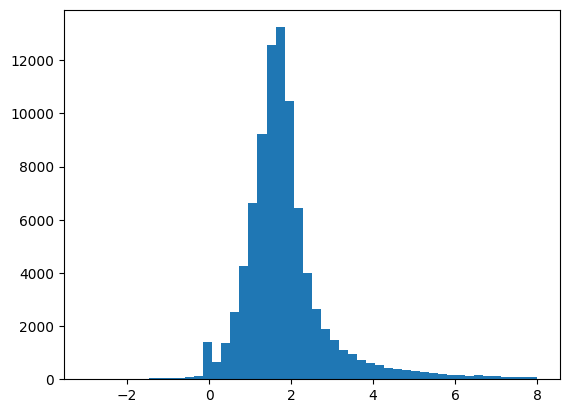

In [62]:
plt.figure()
lifetime_flattened_apr = lifetime_map_apr.flatten()
plt.hist(lifetime_flattened_apr, range = (-3, 8), bins = 50)

### Fitting: confocal vs APR

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:660: RuntimeWarning: invalid value encountered in cast
  idx = (np.floor((variable - self.var_bounds[0]) / (self.var_bounds[1] - self.var_bounds[0]) * N)).astype(int)


<Figure size 900x600 with 0 Axes>

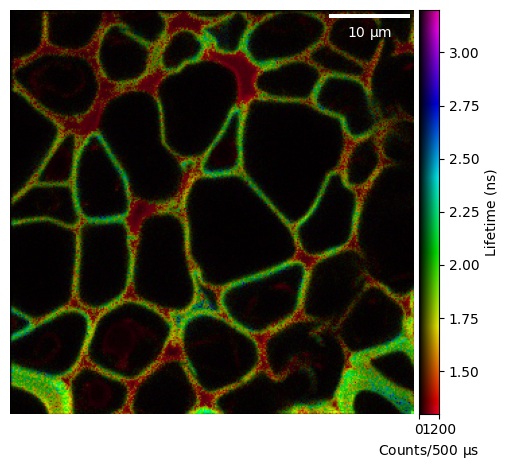

In [63]:
fig = plt.figure(figsize = (9, 6))
gr.show_flim(data_histograms, lifetime_map_apr, pxsize = 0.167, pxdwelltime = 500, lifetime_bounds = (1.3, 3.2), intensity_bounds = (0, 1200), fig = fig)  
fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\Fitting_APR_convallaria_29_07.pdf", dpi = 900)

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:660: RuntimeWarning: invalid value encountered in cast
  idx = (np.floor((variable - self.var_bounds[0]) / (self.var_bounds[1] - self.var_bounds[0]) * N)).astype(int)


<Figure size 900x600 with 0 Axes>

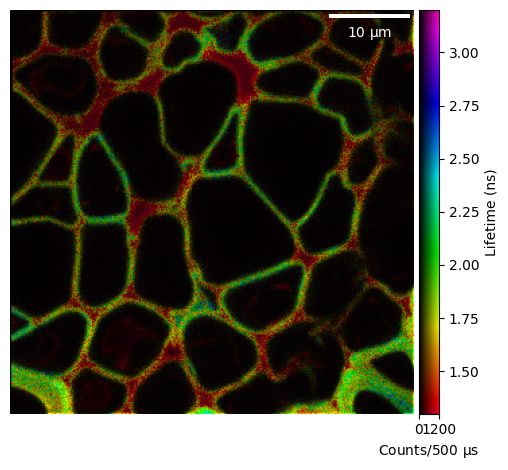

In [64]:
fig = plt.figure(figsize = (9, 6))
gr.show_flim(data_2D, lifetime_map, pxsize = 0.167, pxdwelltime = 500, lifetime_bounds = (1.3, 3.2), intensity_bounds = (0, 1200), fig = fig)  
fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\Fitting_convallaria_29_07.pdf", dpi = 900)

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:660: RuntimeWarning: invalid value encountered in cast
  idx = (np.floor((variable - self.var_bounds[0]) / (self.var_bounds[1] - self.var_bounds[0]) * N)).astype(int)


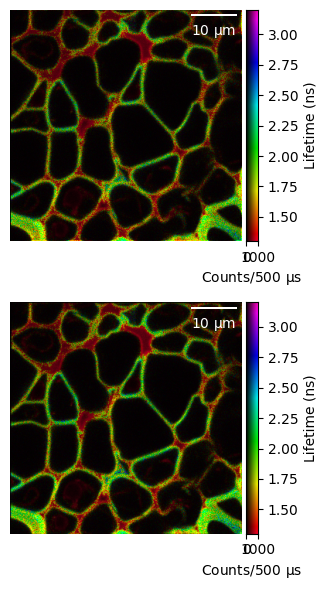

In [65]:
fig = plt.figure(figsize = (9, 6))
gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[2:4, 0:2])
gr.show_flim(data_2D, lifetime_map, pxsize = 0.167, pxdwelltime = 500, lifetime_bounds = (1.3, 3.2), intensity_bounds = (0, 1000), fig = fig, ax = ax1) 
gr.show_flim(data_histograms, lifetime_map_apr, pxsize = 0.167, pxdwelltime = 500, lifetime_bounds = (1.3, 3.2), intensity_bounds = (0, 1000), fig = fig, ax=ax2)
fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\Fitting_Confocal_vs_Fitting_APR_convallaria_29_07.pdf", dpi = 900)

### Tau_m: Confocal vs APR

<Figure size 900x600 with 0 Axes>

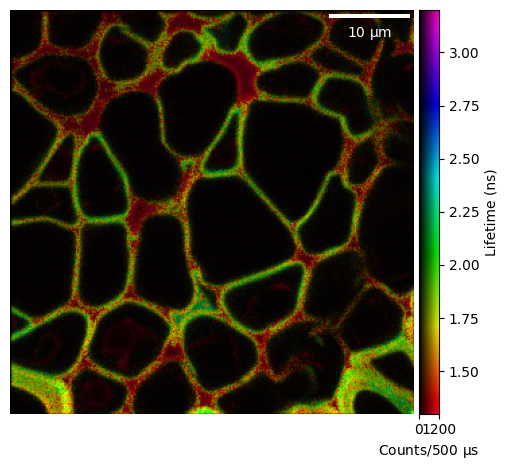

In [135]:
fig = plt.figure(figsize = (9, 6))
gr.show_flim(data_histograms, tau_phi_apr*1e9, pxsize = 0.167, pxdwelltime = 500, lifetime_bounds = (1.3, 3.2), intensity_bounds = (0, 1200), fig = fig)  
fig.tight_layout()

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:660: RuntimeWarning: invalid value encountered in cast
  idx = (np.floor((variable - self.var_bounds[0]) / (self.var_bounds[1] - self.var_bounds[0]) * N)).astype(int)


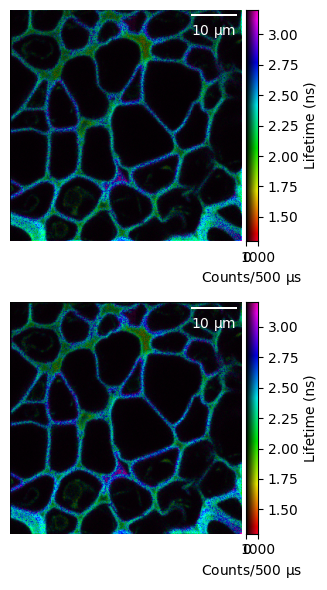

In [66]:
fig = plt.figure(figsize = (9, 6))
gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[2:4, 0:2])
gr.show_flim(data_2D, tau_m_clean*1e9, pxsize = 0.167, pxdwelltime = 500, lifetime_bounds = (1.3, 3.2), intensity_bounds = (0, 1000), fig = fig, ax = ax1)
gr.show_flim(data_histograms, tau_m_apr*1e9, pxsize = 0.167, pxdwelltime = 500, lifetime_bounds = (1.3, 3.2), intensity_bounds = (0, 1000), fig = fig, ax = ax2)  
fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\TauM_Confocal_vs_TauM_APR_convallaria_29_07.pdf", dpi = 900)

### Tau_phi: Confocal vs APR

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:660: RuntimeWarning: invalid value encountered in cast
  idx = (np.floor((variable - self.var_bounds[0]) / (self.var_bounds[1] - self.var_bounds[0]) * N)).astype(int)


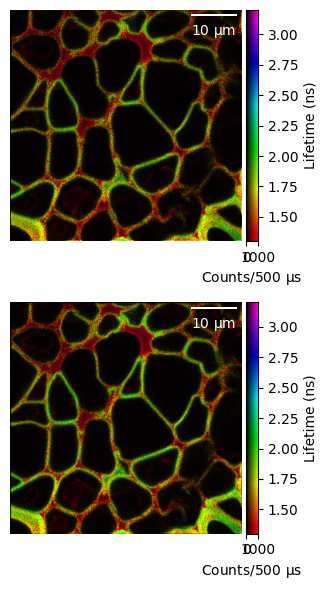

In [67]:
fig = plt.figure(figsize = (9, 6))
gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[2:4, 0:2])
gr.show_flim(data_2D, tau_phi*1e9, pxsize = 0.167, pxdwelltime = 500, lifetime_bounds = (1.3, 3.2), intensity_bounds = (0, 1000), fig = fig, ax = ax1)  
gr.show_flim(data_histograms, tau_phi_apr*1e9, pxsize = 0.167, pxdwelltime = 500, lifetime_bounds = (1.3, 3.2), intensity_bounds = (0, 1000), fig = fig, ax = ax2)  
fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\TauPhi_Confocal_vs_TauPhi_APR_convallaria_29_07.pdf", dpi = 900)

In [80]:
difference_image = lifetime_map_apr - (tau_phi_apr*1e9)

print(difference_image.flatten())

[ 0.01646702 -0.86020639  3.10713378 ... -0.01887087 -0.22436259
 -0.0927506 ]


In [78]:
print(lifetime_map_apr)

[[ 1.86499571e+00 -2.17066086e+00  5.09282930e+00 ...  1.49411991e+00
   2.23566723e+00  1.95115643e+00]
 [-2.84553930e-01  3.10296485e+00  4.22461528e+00 ...  1.56909915e+00
   1.64929205e+00  1.57068457e+00]
 [ 1.91909441e+00 -4.97718598e+00  1.76541061e-02 ...  2.17609544e+00
   1.58735525e+00  1.17396877e+00]
 ...
 [-8.07110354e-01  1.55547909e+01  9.20260322e-01 ...  2.38991361e+00
   1.84832130e+00  2.15829630e+00]
 [-3.92634206e+00  2.76628165e+00  3.81818203e-01 ...  2.32067854e+00
   1.79862624e+00  1.92781716e+00]
 [ 1.68866570e+00  9.00978552e-01  2.81299244e+01 ...  2.27372820e+00
   1.85976451e+00  2.17684846e+00]]


In [79]:
print(tau_phi_apr)

[[ 1.84852869e-09 -1.31045448e-09  1.98569553e-09 ...  1.32134901e-09
   2.65010809e-09  1.35959990e-09]
 [ 6.91933704e-10  1.45931983e-09  2.76849449e-09 ...  1.54455913e-09
   1.44106449e-09  1.37924194e-09]
 [ 1.40991392e-09 -1.12244770e-08  4.96514264e-10 ...  1.55681301e-09
   1.47556592e-09  1.36999584e-09]
 ...
 [ 7.15878194e-09  7.82622492e-09  3.27441279e-10 ...  2.31976358e-09
   1.64714133e-09  1.94139131e-09]
 [-3.16308336e-09  2.23132423e-09  1.79762602e-09 ...  2.07401956e-09
   1.84168744e-09  1.93731936e-09]
 [ 1.55795255e-09  1.57503190e-09  3.42416037e-09 ...  2.29259908e-09
   2.08412710e-09  2.26959905e-09]]


(array([   49.,    48.,    54.,    68.,    75.,    73.,    91.,    98.,
          115.,   122.,   129.,   187.,   179.,   179.,   234.,   276.,
          335.,   353.,   476.,   543.,   668.,   803.,   986.,  1368.,
         1625.,  2062.,  2702.,  4055.,  6259.,  9414., 11893., 10813.,
         7554.,  4761.,  3390.,  2516.,  1957.,  1595.,  1268.,  1027.,
          782.,   674.,   594.,   506.,   408.,   334.,   261.,   248.,
          214.,   200.]),
 array([-3. , -2.9, -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. ,
        -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9,
        -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,
         0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,
         1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ]),
 <BarContainer object of 50 artists>)

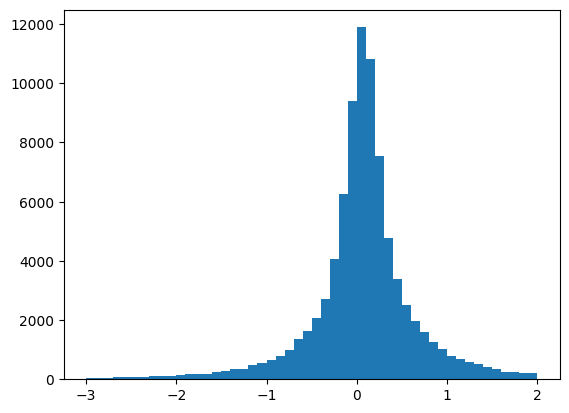

In [82]:
plt.figure()
tau_diff_flat = difference_image.flatten()
plt.hist(tau_diff_flat, range = (-3, 2), bins = 50)

(array([   20.,    18.,    21.,    27.,    24.,    23.,    27.,    33.,
           56.,    50.,    48.,    84.,   107.,  1414.,   665.,  1347.,
         2528.,  4267.,  6629.,  9233., 12567., 13240., 10452.,  6442.,
         4012.,  2641.,  1874.,  1489.,  1091.,   934.,   716.,   617.,
          523.,   422.,   380.,   344.,   304.,   256.,   229.,   195.,
          176.,   156.,   141.,   154.,   109.,   111.,   102.,    98.,
           85.,    80.]),
 array([-3.  , -2.78, -2.56, -2.34, -2.12, -1.9 , -1.68, -1.46, -1.24,
        -1.02, -0.8 , -0.58, -0.36, -0.14,  0.08,  0.3 ,  0.52,  0.74,
         0.96,  1.18,  1.4 ,  1.62,  1.84,  2.06,  2.28,  2.5 ,  2.72,
         2.94,  3.16,  3.38,  3.6 ,  3.82,  4.04,  4.26,  4.48,  4.7 ,
         4.92,  5.14,  5.36,  5.58,  5.8 ,  6.02,  6.24,  6.46,  6.68,
         6.9 ,  7.12,  7.34,  7.56,  7.78,  8.  ]),
 <BarContainer object of 50 artists>)

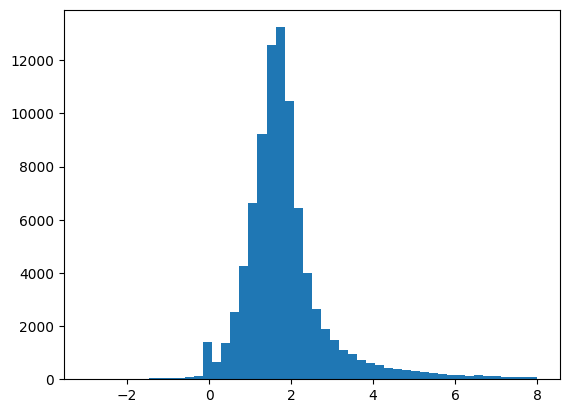

In [77]:
plt.figure()
plt.hist(lifetime_flattened_apr, range = (-3, 8), bins = 50)

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:660: RuntimeWarning: invalid value encountered in cast
  idx = (np.floor((variable - self.var_bounds[0]) / (self.var_bounds[1] - self.var_bounds[0]) * N)).astype(int)


<Figure size 900x600 with 0 Axes>

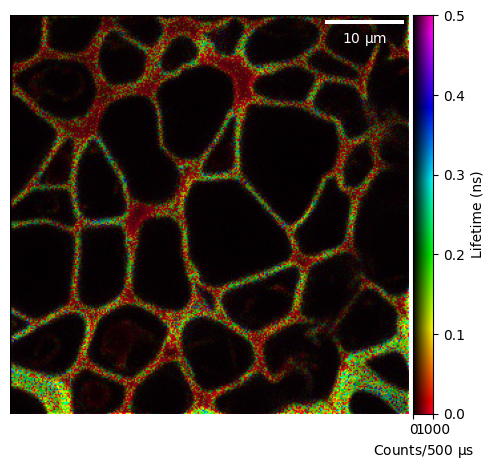

In [87]:
fig = plt.figure(figsize = (9, 6))

gr.show_flim(data_2D, difference_image, pxsize = 0.167, pxdwelltime = 500, lifetime_bounds = (0, 0.5), intensity_bounds = (0, 1000), fig = fig)  

fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\Difference_fitting_tau_phi_APR_convallaria_29_07.pdf", dpi = 900)

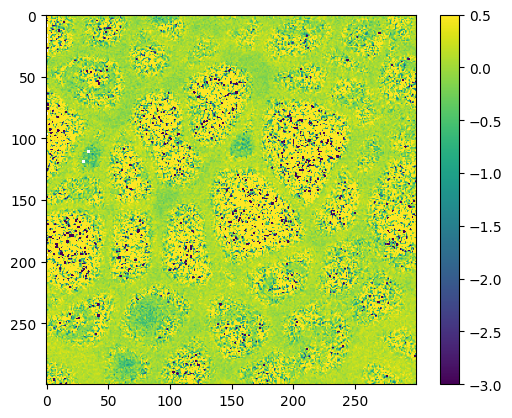

In [118]:
plt.figure()
from matplotlib_scalebar.scalebar import ScaleBar
c= plt.imshow(difference_image, vmin=-3, vmax=0.5, cmap='viridis')
plt.colorbar(c) 
  

<function matplotlib.pyplot.show(close=None, block=None)>

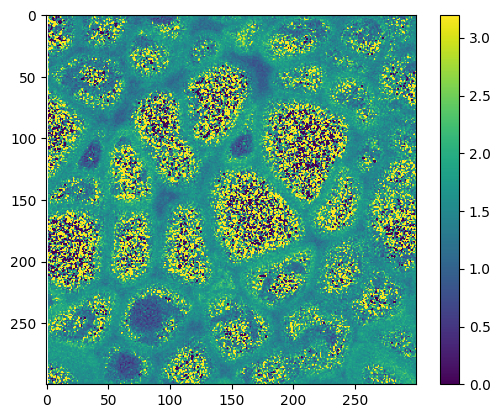

In [116]:
plt.figure()

c= plt.imshow(tau_phi*1e9, vmin=0, vmax=3.2, cmap='viridis')
plt.colorbar()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

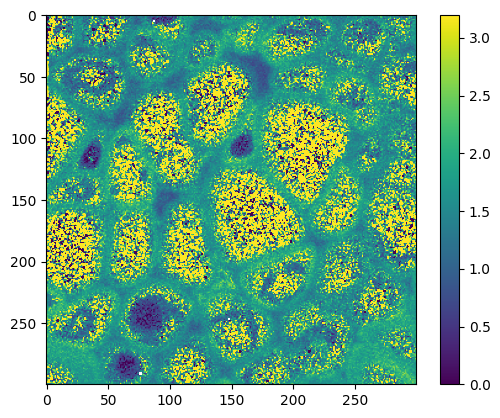

In [115]:
plt.figure()

c= plt.imshow(lifetime_map, vmin=0, vmax=3.2, cmap='viridis')
plt.colorbar()
plt.show

In [95]:
print(tau_phi.shape)

(300, 300)


### show APR

In [131]:

pxsizex = 0.167
N = 25
usf = 100
ref = N//2

shift, img_ism = apr.APR(image_3d, usf, ref, pxsize = 2*pxsizex)

img_ism_sum = img_ism.sum(axis=-1)

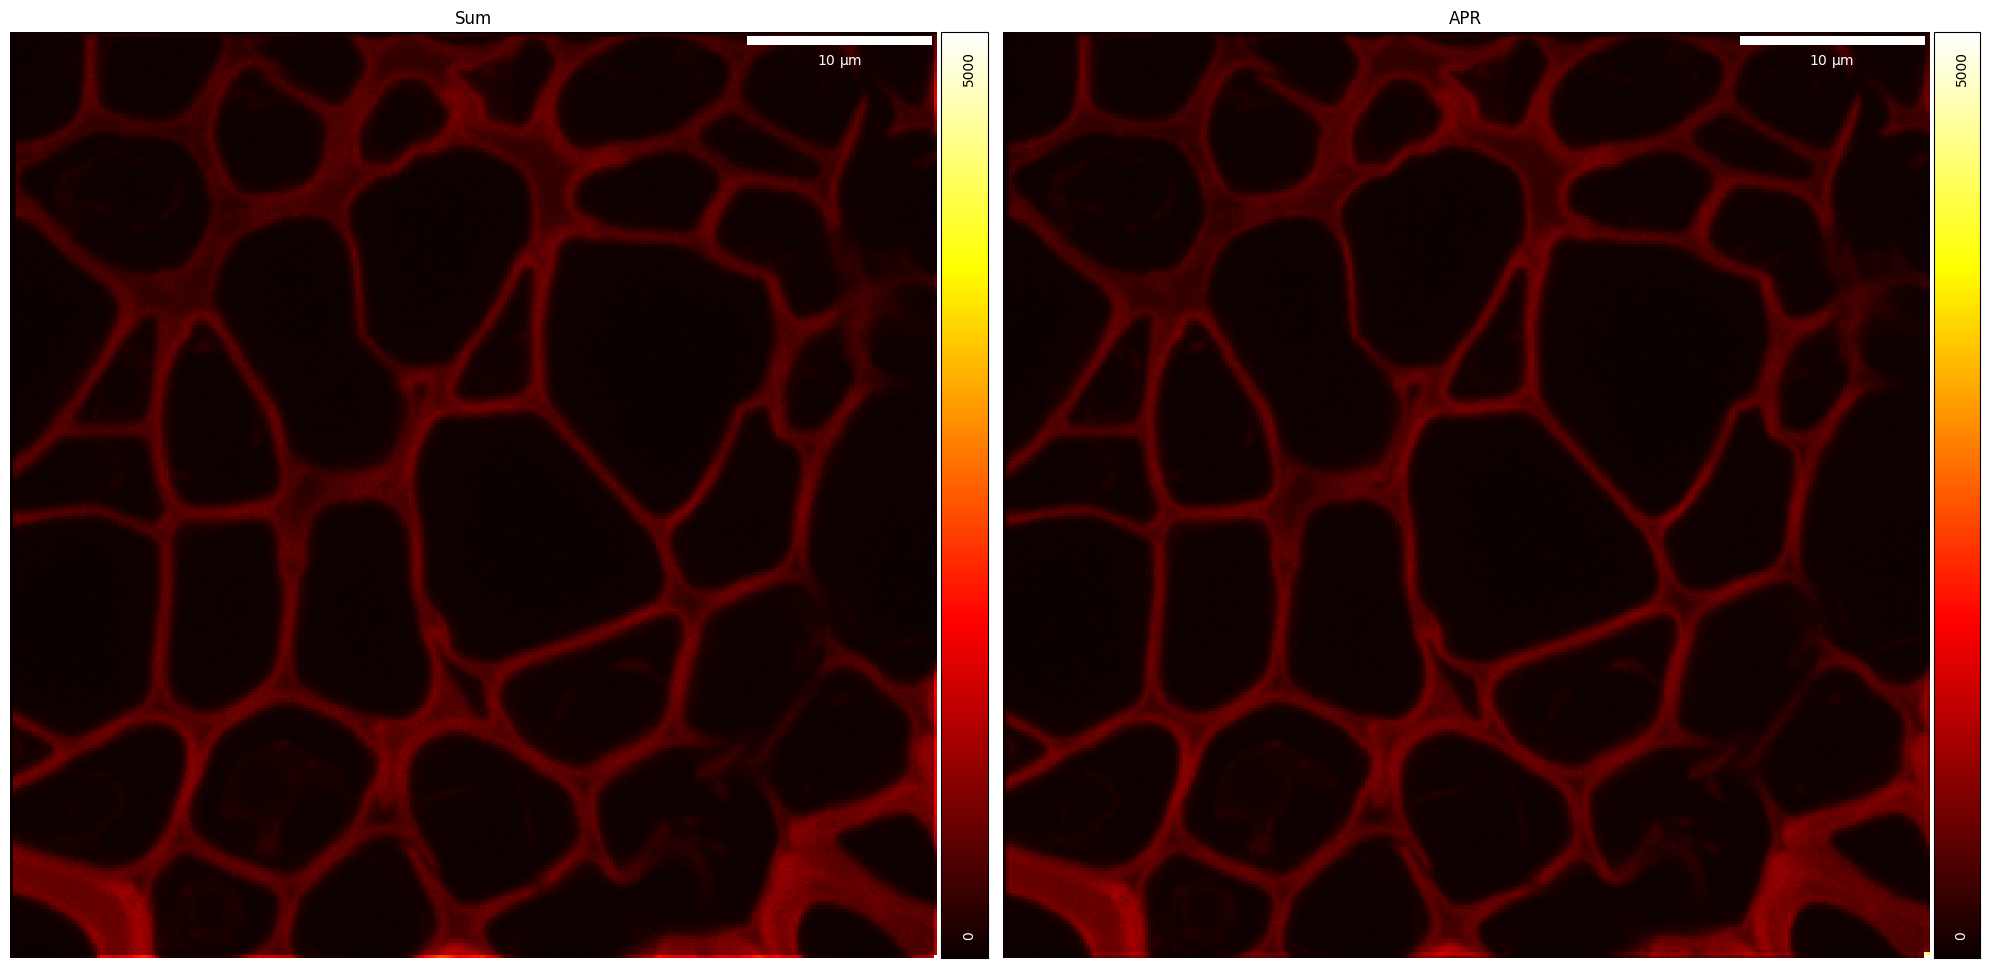

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

gr.ShowImg(data_2D, pxsize_x = pxsizex, vmin = 0, vmax = 5000, fig = fig, ax = ax[0])
ax[0].set_title('Sum')

gr.ShowImg(img_ism_sum, pxsize_x = pxsizex, vmin = 0, vmax = 5000, fig = fig, ax = ax[1])
ax[1].set_title('APR')



fig.tight_layout()